In [1]:
from sklearn.datasets import make_classification
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
import os
import xgboost as xgb
from sklearn.preprocessing import label_binarize

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plotROC(n_classes,y_test,y_score):
    # 计算
    fpr, tpr, thread = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    # 绘图
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc.png',)
    plt.show()

# 计算准确率
def calculate_all_prediction(confMatrix):
    '''
    计算总精度,对角线上所有值除以总数
    :return:
    '''
    total_sum = confMatrix.sum()
    correct_sum = (np.diag(confMatrix)).sum()
    prediction = round(100 * float(correct_sum) / float(total_sum), 2)
    print('准确率:' + str(prediction) + '%')


def calculae_lable_prediction(confMatrix):
    '''
    计算每一个类别的预测精度:该类被预测正确的数除以该类的总数
    '''
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=1)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('精确率: {0} : {1} %'.format(i, prediction))

def calculate_label_recall(confMatrix):
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=0)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('召回率: {0} : {1} %'.format(i, prediction))

In [3]:
file = '代谢组数据 - 填充 by min - 副本2.csv'
df = pd.read_csv(file,engine='python')
features=df.columns.tolist()

feat_labels = df.columns[5:]
X=df[features[6:]]
y=df[features[4]]


pd.DataFrame(y)
pd.DataFrame(X)

,Pyridoxamine,Pyroglutamic acid,Serine,Stearoylcarnitine,Taurine,Threonine,Trigonelline,Trimethylamine-N-oxide,Tryptophan,Tyrosine,...,GlcCer(d18:1/24:0),GlcCer(d18:1/16:0),Glucosylsphingosine,GlcCer(d18:2/18:0),GlcCer(d18:2/20:0),GlcCer(d18:1/18:0),GlcCer(d18:1/22:1),GalCer(d18:1/16:0),GalCer(d18:2/20:0),GalCer(d18:2/18:0)
0,0.352458,3.675633,16.053034,0.006717,0.288872,16.296357,0.496333,0.750501,0.328595,0.033050,...,0.118273,0.367976,0.003247,0.010075,0.021066,0.025433,0.014106,0.057368,0.008590,0.003784
1,0.323059,2.999227,9.355140,0.003421,0.181894,10.858957,0.717211,0.735815,0.175502,0.020829,...,0.187542,0.642420,0.002448,0.009385,0.014691,0.036326,0.014233,0.074351,0.005446,0.003105
2,0.471222,4.150903,12.354985,0.008192,0.227918,13.796057,5.414483,1.677398,0.227589,0.023769,...,0.200776,0.477493,0.003626,0.006132,0.012182,0.027445,0.017611,0.050879,0.003709,0.002176
3,0.342884,4.343997,15.476615,0.003851,0.173863,20.367893,0.633347,1.223389,0.271947,0.024958,...,0.141479,0.297837,0.005757,0.005930,0.011039,0.022532,0.010267,0.061450,0.002993,0.002515
4,0.467971,3.067275,13.792753,0.005544,0.178380,16.238507,0.396870,1.696055,0.179668,0.035810,...,0.141609,0.402012,0.002500,0.008307,0.011659,0.036490,0.013533,0.047800,0.003884,0.001682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,0.308284,3.520729,12.981925,0.007905,0.192906,11.699659,1.851143,1.146580,0.167807,0.017373,...,0.158299,0.514225,0.004606,0.009526,0.013358,0.046152,0.018665,0.072062,0.003888,0.004825
483,0.383401,3.329386,11.351226,0.005165,0.215383,10.826516,3.582773,0.933229,0.198223,0.019193,...,0.127828,0.357650,0.002990,0.005657,0.009929,0.025064,0.010088,0.071673,0.005497,0.003749
484,0.371568,3.315927,9.338606,0.008439,0.279232,11.244900,0.331485,1.284491,0.208336,0.021417,...,0.105910,0.294475,0.002072,0.006899,0.008220,0.025450,0.010124,0.035590,0.002237,0.001742
485,0.457592,3.173328,11.145853,0.004172,0.234835,11.202486,1.049095,1.507327,0.278813,0.020578,...,0.166906,0.527150,0.002083,0.009465,0.012181,0.036753,0.016063,0.072767,0.003339,0.001423


,Pyridoxamine,Pyroglutamic acid,Serine,Stearoylcarnitine,Taurine,Threonine,Trigonelline,Trimethylamine-N-oxide,Tryptophan,Tyrosine,...,GlcCer(d18:1/24:0),GlcCer(d18:1/16:0),Glucosylsphingosine,GlcCer(d18:2/18:0),GlcCer(d18:2/20:0),GlcCer(d18:1/18:0),GlcCer(d18:1/22:1),GalCer(d18:1/16:0),GalCer(d18:2/20:0),GalCer(d18:2/18:0)
0,0.352458,3.675633,16.053034,0.006717,0.288872,16.296357,0.496333,0.750501,0.328595,0.033050,...,0.118273,0.367976,0.003247,0.010075,0.021066,0.025433,0.014106,0.057368,0.008590,0.003784
1,0.323059,2.999227,9.355140,0.003421,0.181894,10.858957,0.717211,0.735815,0.175502,0.020829,...,0.187542,0.642420,0.002448,0.009385,0.014691,0.036326,0.014233,0.074351,0.005446,0.003105
2,0.471222,4.150903,12.354985,0.008192,0.227918,13.796057,5.414483,1.677398,0.227589,0.023769,...,0.200776,0.477493,0.003626,0.006132,0.012182,0.027445,0.017611,0.050879,0.003709,0.002176
3,0.342884,4.343997,15.476615,0.003851,0.173863,20.367893,0.633347,1.223389,0.271947,0.024958,...,0.141479,0.297837,0.005757,0.005930,0.011039,0.022532,0.010267,0.061450,0.002993,0.002515
4,0.467971,3.067275,13.792753,0.005544,0.178380,16.238507,0.396870,1.696055,0.179668,0.035810,...,0.141609,0.402012,0.002500,0.008307,0.011659,0.036490,0.013533,0.047800,0.003884,0.001682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,0.308284,3.520729,12.981925,0.007905,0.192906,11.699659,1.851143,1.146580,0.167807,0.017373,...,0.158299,0.514225,0.004606,0.009526,0.013358,0.046152,0.018665,0.072062,0.003888,0.004825
483,0.383401,3.329386,11.351226,0.005165,0.215383,10.826516,3.582773,0.933229,0.198223,0.019193,...,0.127828,0.357650,0.002990,0.005657,0.009929,0.025064,0.010088,0.071673,0.005497,0.003749
484,0.371568,3.315927,9.338606,0.008439,0.279232,11.244900,0.331485,1.284491,0.208336,0.021417,...,0.105910,0.294475,0.002072,0.006899,0.008220,0.025450,0.010124,0.035590,0.002237,0.001742
485,0.457592,3.173328,11.145853,0.004172,0.234835,11.202486,1.049095,1.507327,0.278813,0.020578,...,0.166906,0.527150,0.002083,0.009465,0.012181,0.036753,0.016063,0.072767,0.003339,0.001423


,Pyridoxamine,Pyroglutamic acid,Serine,Stearoylcarnitine,Taurine,Threonine,Trigonelline,Trimethylamine-N-oxide,Tryptophan,Tyrosine,...,GlcCer(d18:1/24:0),GlcCer(d18:1/16:0),Glucosylsphingosine,GlcCer(d18:2/18:0),GlcCer(d18:2/20:0),GlcCer(d18:1/18:0),GlcCer(d18:1/22:1),GalCer(d18:1/16:0),GalCer(d18:2/20:0),GalCer(d18:2/18:0)
0,0.352458,3.675633,16.053034,0.006717,0.288872,16.296357,0.496333,0.750501,0.328595,0.033050,...,0.118273,0.367976,0.003247,0.010075,0.021066,0.025433,0.014106,0.057368,0.008590,0.003784
1,0.323059,2.999227,9.355140,0.003421,0.181894,10.858957,0.717211,0.735815,0.175502,0.020829,...,0.187542,0.642420,0.002448,0.009385,0.014691,0.036326,0.014233,0.074351,0.005446,0.003105
2,0.471222,4.150903,12.354985,0.008192,0.227918,13.796057,5.414483,1.677398,0.227589,0.023769,...,0.200776,0.477493,0.003626,0.006132,0.012182,0.027445,0.017611,0.050879,0.003709,0.002176
3,0.342884,4.343997,15.476615,0.003851,0.173863,20.367893,0.633347,1.223389,0.271947,0.024958,...,0.141479,0.297837,0.005757,0.005930,0.011039,0.022532,0.010267,0.061450,0.002993,0.002515
4,0.467971,3.067275,13.792753,0.005544,0.178380,16.238507,0.396870,1.696055,0.179668,0.035810,...,0.141609,0.402012,0.002500,0.008307,0.011659,0.036490,0.013533,0.047800,0.003884,0.001682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,0.308284,3.520729,12.981925,0.007905,0.192906,11.699659,1.851143,1.146580,0.167807,0.017373,...,0.158299,0.514225,0.004606,0.009526,0.013358,0.046152,0.018665,0.072062,0.003888,0.004825
483,0.383401,3.329386,11.351226,0.005165,0.215383,10.826516,3.582773,0.933229,0.198223,0.019193,...,0.127828,0.357650,0.002990,0.005657,0.009929,0.025064,0.010088,0.071673,0.005497,0.003749
484,0.371568,3.315927,9.338606,0.008439,0.279232,11.244900,0.331485,1.284491,0.208336,0.021417,...,0.105910,0.294475,0.002072,0.006899,0.008220,0.025450,0.010124,0.035590,0.002237,0.001742
485,0.457592,3.173328,11.145853,0.004172,0.234835,11.202486,1.049095,1.507327,0.278813,0.020578,...,0.166906,0.527150,0.002083,0.009465,0.012181,0.036753,0.016063,0.072767,0.003339,0.001423


RF-RFE
#

In [4]:
# RFECV


from sklearn.svm import SVC

forest = RandomForestClassifier(criterion='gini',n_estimators=200,random_state=1,n_jobs=2,verbose=1)

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=forest,  # 学习器
              min_features_to_select=2,  # 最小选择的特征数量
              step=1,  # 移除特征个数
              cv=StratifiedKFold(10),  # 交叉验证次数
              scoring='accuracy',  # 学习器的评价标准
              verbose=0,
              n_jobs=-1
              ).fit(X, y)
X_RFECV = rfecv.transform(X)
print("RFECV特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfecv.n_features_)
print("全部特征等级 : %s" % list(rfecv.ranking_))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Us

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s f

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Do

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s f

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s f

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

RFECV特征选择结果——————————————————————————————————————————————————
有效特征个数 : 10
全部特征等级 : [167, 199, 178, 23, 79, 128, 11, 24, 140, 93, 119, 98, 108, 56, 196, 105, 127, 20, 124, 151, 30, 34, 58, 138, 50, 174, 47, 90, 59, 64, 155, 70, 81, 32, 189, 78, 100, 213, 39, 118, 215, 205, 6, 83, 77, 133, 1, 36, 173, 82, 16, 88, 1, 8, 17, 5, 1, 2, 1, 1, 1, 1, 68, 203, 156, 135, 136, 4, 9, 12, 60, 168, 125, 106, 214, 160, 191, 104, 225, 147, 66, 179, 206, 184, 200, 223, 54, 209, 65, 25, 204, 169, 110, 176, 33, 86, 159, 13, 67, 101, 190, 46, 19, 85, 134, 210, 208, 224, 165, 120, 145, 161, 122, 48, 27, 142, 153, 201, 126, 183, 117, 96, 207, 31, 143, 194, 180, 171, 219, 92, 40, 94, 61, 43, 212, 141, 102, 172, 175, 227, 195, 228, 115, 53, 38, 164, 22, 150, 181, 149, 148, 226, 7, 187, 137, 14, 111, 49, 18, 1, 44, 216, 162, 76, 170, 35, 222, 211, 114, 144, 71, 62, 75, 74, 72, 103, 157, 55, 182, 69, 89, 26, 41, 21, 132, 220, 217, 57, 95, 152, 29, 221, 166, 130, 186, 99, 73, 113, 80, 28, 45, 63, 107, 154, 87, 16

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


In [5]:
selected_features = X.columns[rfecv.support_]
print(list(selected_features))
print("交叉验证得分————————————————————————————————————————————")
print(rfecv.cv_results_["mean_test_score"])
U=X[selected_features]
X_train, X_test, Y_train, Y_test = train_test_split(U, y, test_size=0.2)

['3-Methoxytyrosine', 'Histamine', 'Dopamine 3-o-sulfate', 'Ascorbate', 'Dopa', 'Dopamine 4-o-sulfate', 'Putrescine', 'LPC(26:1)', 'LPG(18:0)', 'PG(16:0_20:4)']
交叉验证得分————————————————————————————————————————————
[0.90761054 0.93439626 0.93843537 0.95093537 0.95089286 0.94681122
 0.95289116 0.94672619 0.96313776 0.95293367 0.96109694 0.95289116
 0.95080782 0.94876701 0.95080782 0.94876701 0.95488946 0.94672619
 0.95284864 0.95484694 0.95488946 0.95488946 0.95484694 0.95693027
 0.95284864 0.95488946 0.95484694 0.95284864 0.94876701 0.95284864
 0.95284864 0.95284864 0.95080782 0.95284864 0.95080782 0.95488946
 0.95488946 0.94876701 0.95280612 0.95484694 0.94460034 0.95289116
 0.94876701 0.95280612 0.95488946 0.95080782 0.95080782 0.94464286
 0.95076531 0.95484694 0.95280612 0.94668367 0.94672619 0.94876701
 0.95076531 0.95484694 0.94668367 0.94872449 0.95080782 0.95080782
 0.95280612 0.95076531 0.95693027 0.95076531 0.95080782 0.95076531
 0.95484694 0.95484694 0.95280612 0.9610119  0.9569

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 ta

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.247124
 2) PG(16:0_20:4)                  0.177993
 3) Dopamine 4-o-sulfate           0.177741
 4) Ascorbate                      0.162379
 5) 3-Methoxytyrosine              0.119578
 6) LPC(26:1)                      0.029583
 7) Dopamine 3-o-sulfate           0.024191
 8) LPG(18:0)                      0.022614
 9) Histamine                      0.021094
10) Dopa                           0.017703
准确率:92.86%
精确率: 0 : 87.18 %
精确率: 1 : 96.61 %
召回率: 0 : 94.44 %
召回率: 1 : 91.94 %
特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.247124
 2) PG(16:0_20:4)                  0.177993
 3) Dopamine 4-o-sulfate           0.177741
 4) Ascorbate                      0.162379
 5) 3-Methoxytyrosine              0.119578
 6) LPC(26:1)                      0.029583
 7) Dopamine 3-o-sulfate           0.024191
 8) LPG(18:0)                      0.022614
 9) Histamine  

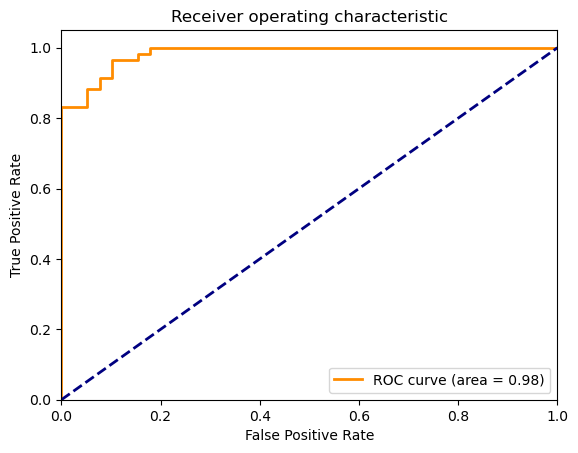

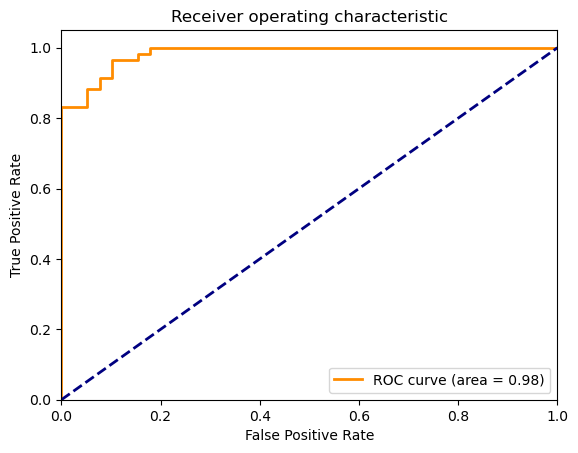

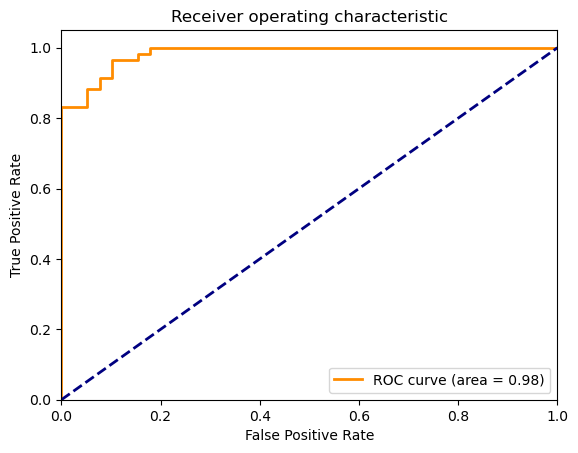

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 170 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 197 out of 200 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 170 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 197 out of 200 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    3.2s finished
[Paral

[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs

交叉验证得分：
[0.97435897 0.94871795 1.         0.94871795 0.92307692 1.
 0.94871795 0.94871795 0.97435897 1.        ]
0.9666666666666666
交叉验证得分：
[0.97435897 0.94871795 1.         0.94871795 0.92307692 1.
 0.94871795 0.94871795 0.97435897 1.        ]
0.9666666666666666
交叉验证得分：
[0.97435897 0.94871795 1.         0.94871795 0.92307692 1.
 0.94871795 0.94871795 0.97435897 1.        ]
0.9666666666666666


[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | 

In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini',max_features=25,n_estimators=200,random_state=1,n_jobs=2,verbose=1)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, selected_features[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

XGB-RFE#

In [7]:
# RFECV
import xgboost as xgb

model = xgb.XGBClassifier( learning_rate =0.1,
 n_estimators=200,
 max_depth=5)

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=model,  # 学习器
              min_features_to_select=2,  # 最小选择的特征数量
              step=1,  # 移除特征个数
              cv=StratifiedKFold(10),  # 交叉验证次数
              scoring='accuracy',  # 学习器的评价标准
              verbose=0,
              n_jobs=-1
              ).fit(X, y)
X_RFECV = rfecv.transform(X)
print("RFECV特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfecv.n_features_)
print("全部特征等级 : %s" % list(rfecv.ranking_))

RFECV特征选择结果——————————————————————————————————————————————————
有效特征个数 : 67
全部特征等级 : [58, 82, 80, 78, 1, 73, 1, 1, 36, 49, 69, 88, 1, 4, 71, 1, 94, 1, 81, 40, 33, 1, 1, 101, 18, 72, 119, 3, 1, 123, 110, 60, 1, 1, 50, 12, 1, 39, 44, 20, 135, 137, 1, 22, 138, 43, 1, 149, 13, 1, 150, 64, 1, 1, 160, 48, 1, 1, 1, 41, 1, 1, 99, 98, 53, 89, 1, 1, 11, 67, 165, 1, 1, 45, 62, 59, 106, 124, 125, 107, 46, 120, 109, 126, 2, 128, 54, 129, 1, 6, 114, 130, 116, 117, 140, 141, 51, 1, 1, 24, 145, 9, 1, 52, 85, 65, 83, 37, 142, 38, 35, 30, 156, 1, 5, 166, 1, 8, 171, 66, 68, 47, 77, 1, 113, 1, 79, 86, 61, 70, 87, 93, 23, 1, 1, 100, 1, 157, 1, 55, 118, 1, 163, 162, 1, 121, 132, 1, 16, 1, 34, 131, 134, 1, 1, 1, 146, 1, 1, 1, 1, 1, 63, 1, 136, 148, 1, 56, 154, 153, 1, 152, 32, 1, 1, 151, 147, 139, 133, 143, 27, 158, 15, 17, 164, 168, 167, 161, 155, 144, 19, 112, 102, 1, 127, 42, 115, 159, 105, 25, 1, 31, 28, 92, 111, 122, 10, 1, 95, 21, 1, 108, 1, 1, 104, 1, 103, 57, 96, 1, 1, 97, 1, 7, 91, 90, 84, 74, 1, 26, 

In [8]:
selected_features = X.columns[rfecv.support_]
print(list(selected_features))
print("交叉验证得分————————————————————————————————————————————")
print(rfecv.cv_results_["mean_test_score"])
U=X[selected_features]
X_train, X_test, Y_train, Y_test = train_test_split(U, y, test_size=0.2)

['Taurine', 'Trigonelline', 'Trimethylamine-N-oxide', 'Valine', "5'-Methylthioadenosine", 'Caffeine', 'Paraxanthine', 'Piperine', 'Uric acid', 'Melatonin', 'Sucrose', 'Cadaverine', 'Bilirubin', '3-Methoxytyrosine', 'N-Alpha-acetyllysine', 'Histamine', '7-Methylxanthine', 'Dopamine 3-o-sulfate', 'Glutathione', 'Ascorbate', 'Dopamine 4-o-sulfate', 'Putrescine', 'Glucose 6-phosphate', 'Erythose 4-phosphate', 'CE(18:1)', 'CE(18:2)', 'GB3(d18:1/16:0)', 'LacCer(d18:1/16:0)', 'LacCer(d18:1/18:0)', 'LPC(16:1)', 'PC(34:1)', 'PC(36:4)', 'PC(O-18:0/2:0)', 'PE(36:1)', 'PE(40:7)', 'SM(d18:1/16:0)', 'SM(d18:1/24:0)', 'TG(18:0_36:2)', 'TG(20:4_32:1)', 'TG(20:4_36:2)', 'Cholesterol', 'LPC(26:0)', '7-keto-Cholesterol', 'Palmitoylethanolamine', 'TG(22:6_38:1)', 'Sphinganine', 'MG(18:0)', 'LPC(26:1)', '(3-O-sulfo)GalCer(d18:1/16:0)', '(3-O-sulfo)GalCer(d18:1/18:0(2OH)', '(3-O-sulfo)GalCer(d18:1/24:0(2OH))', '(3-O-sulfo)GalCer(d18:1/24:1)', 'GM3(d34:1)', 'LPE(18:0)', 'LPI(18:0)', 'PI(16:0_18:1)', 'Stearic

特征排序结果——————————————————————————————————————————————————
 1) 7-Methylxanthine               0.116938
 2) Putrescine                     0.113529
 3) PG(16:0_20:4)                  0.106445
 4) Ascorbate                      0.095540
 5) Dopamine 4-o-sulfate           0.053979
 6) 3-Methoxytyrosine              0.053945
 7) LPC(26:1)                      0.035839
 8) PC(O-18:0/2:0)                 0.031998
 9) Histamine                      0.028066
10) SM(d18:1/24:0)                 0.019293
11) TG(18:0_36:2)                  0.018786
12) TG(20:4_36:2)                  0.018688
13) Erythose 4-phosphate           0.018613
14) Palmitoylethanolamine          0.018290
15) LPG(18:0)                      0.017789
16) Stearic acid                   0.015108
17) Valine                         0.014841
18) Melatonin                      0.012103
19) LPI(18:0)                      0.011044
20) Dopamine 3-o-sulfate           0.010900
21) Bilirubin                      0.010374
22) PE(36:1)       

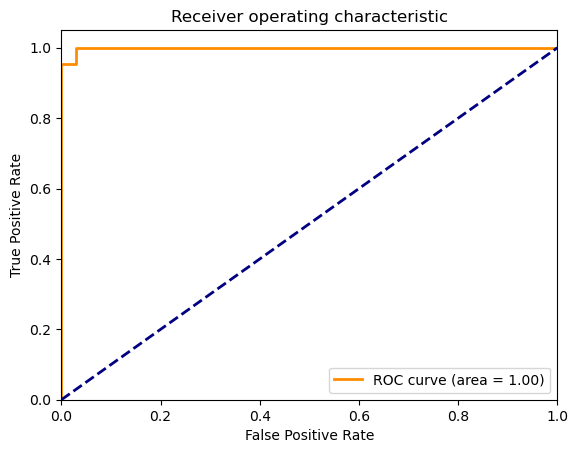

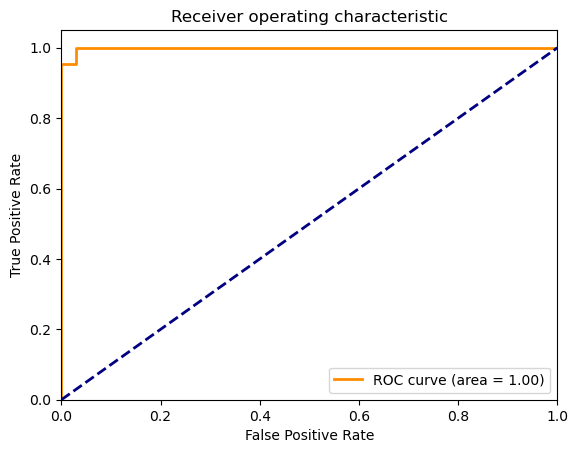

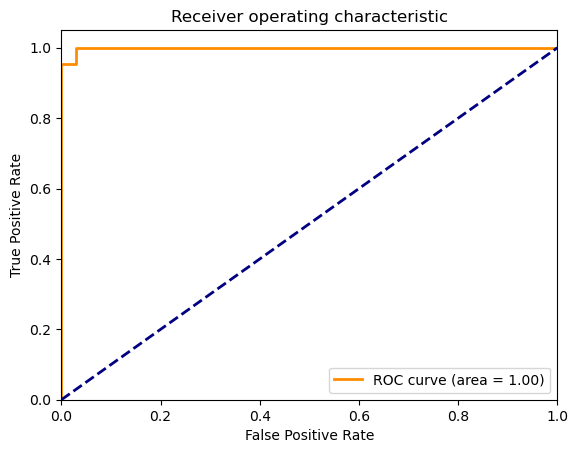

交叉验证得分：
[0.94871795 0.92307692 0.97435897 0.97435897 0.94871795 0.97435897
 1.         0.8974359  0.92307692 0.97368421]
0.9537786774628879
交叉验证得分：
[0.94871795 0.92307692 0.97435897 0.97435897 0.94871795 0.97435897
 1.         0.8974359  0.92307692 0.97368421]
0.9537786774628879
交叉验证得分：
[0.94871795 0.92307692 0.97435897 0.97435897 0.94871795 0.97435897
 1.         0.8974359  0.92307692 0.97368421]
0.9537786774628879


In [9]:
model = xgb.XGBClassifier( learning_rate =0.1,
 n_estimators=200,
 max_depth=5)

model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, selected_features[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

SVM-RFE#

In [10]:
# RFECV
from sklearn import svm

model = svm.SVC(kernel = 'linear')

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=model,  # 学习器
              min_features_to_select=2,  # 最小选择的特征数量
              step=1,  # 移除特征个数
              cv=StratifiedKFold(10),  # 交叉验证次数
              scoring='accuracy',  # 学习器的评价标准
              verbose=0,
              n_jobs=-1
              ).fit(X, y)
X_RFECV = rfecv.transform(X)
print("RFECV特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfecv.n_features_)
print("全部特征等级 : %s" % list(rfecv.ranking_))

RFECV特征选择结果——————————————————————————————————————————————————
有效特征个数 : 15
全部特征等级 : [5, 56, 175, 114, 21, 155, 103, 107, 154, 92, 1, 199, 39, 115, 163, 151, 7, 69, 160, 83, 4, 1, 25, 3, 157, 165, 130, 132, 193, 84, 100, 152, 158, 108, 123, 180, 124, 196, 1, 170, 185, 191, 210, 104, 102, 64, 1, 184, 219, 177, 9, 183, 12, 101, 77, 190, 1, 80, 42, 24, 1, 1, 113, 194, 129, 153, 128, 206, 188, 8, 91, 178, 211, 182, 203, 209, 63, 66, 147, 200, 117, 141, 74, 59, 18, 1, 79, 96, 161, 1, 13, 1, 109, 26, 57, 1, 81, 23, 169, 118, 149, 31, 68, 35, 110, 47, 142, 139, 223, 146, 49, 28, 27, 201, 88, 46, 144, 137, 97, 148, 44, 82, 181, 135, 19, 45, 143, 70, 112, 16, 122, 78, 50, 41, 173, 126, 217, 150, 75, 72, 60, 14, 34, 37, 15, 65, 51, 119, 197, 222, 89, 120, 164, 61, 212, 220, 218, 127, 195, 140, 20, 125, 30, 208, 2, 1, 1, 94, 205, 105, 6, 116, 90, 71, 1, 221, 186, 106, 159, 76, 166, 67, 95, 10, 33, 40, 167, 86, 111, 43, 32, 138, 53, 48, 192, 17, 29, 156, 1, 62, 145, 55, 36, 11, 99, 198, 213, 131, 93

In [11]:
selected_features = X.columns[rfecv.support_]
print(list(selected_features))
print("交叉验证得分————————————————————————————————————————————")
print(rfecv.cv_results_["mean_test_score"])
U=X[selected_features]
X_train, X_test, Y_train, Y_test = train_test_split(U, y, test_size=0.2)

['Uridine', 'Paraxanthine', '1-Methylhistidine', '3-Methoxytyrosine', 'Dopamine 3-o-sulfate', 'Dopamine 4-o-sulfate', 'Putrescine', 'DG(18:0_20:4)', 'GB3(d18:1/18:0)', 'GB3(d18:1/24:1)', 'HexCer(d18:1/24:0)', '(3-O-sulfo)GalCer(d18:1/24:1(2OH))', '(3-O-sulfo)GalCer(d18:1/24:1)', 'LPI(18:0)', 'PI(18:0_22:6)']
交叉验证得分————————————————————————————————————————————
[0.68996599 0.70620748 0.72253401 0.69596088 0.69183673 0.68771259
 0.70004252 0.69192177 0.68979592 0.69392007 0.70616497 0.72886905
 0.73090986 0.74115646 0.71045918 0.71853741 0.71228741 0.70607993
 0.71840986 0.70616497 0.7204932  0.71645408 0.70820578 0.7184949
 0.7184949  0.7184949  0.71441327 0.72057823 0.71437075 0.7122449
 0.71232993 0.71641156 0.71432823 0.72257653 0.73078231 0.72253401
 0.71632653 0.7122449  0.70616497 0.70820578 0.69791667 0.70403912
 0.70812075 0.70603741 0.70603741 0.7059949  0.69783163 0.69778912
 0.6957483  0.70403912 0.7        0.70004252 0.70216837 0.69812925
 0.70021259 0.7022534  0.70221088 0.71

特征排序结果——————————————————————————————————————————————————
(15,)
(15,)
 1) 3-Methoxytyrosine              2.410474
 2) Dopamine 3-o-sulfate           2.192077
 3) Dopamine 4-o-sulfate           1.575798
 4) (3-O-sulfo)GalCer(d18:1/24:1(2OH)) 1.501609
 5) 1-Methylhistidine              1.338892
 6) DG(18:0_20:4)                  1.267737
 7) HexCer(d18:1/24:0)             1.256632
 8) Putrescine                     1.192885
 9) PI(18:0_22:6)                  1.078487
10) Paraxanthine                   1.078099
11) GB3(d18:1/24:1)                1.005348
12) LPI(18:0)                      1.003880
13) (3-O-sulfo)GalCer(d18:1/24:1)  0.977197
14) GB3(d18:1/18:0)                0.892343
15) Uridine                        0.491704
准确率:80.61%
精确率: 0 : 73.17 %
精确率: 1 : 85.96 %
召回率: 0 : 78.95 %
召回率: 1 : 81.67 %
特征排序结果——————————————————————————————————————————————————
(15,)
(15,)
 1) 3-Methoxytyrosine              2.410474
 2) Dopamine 3-o-sulfate           2.192077
 3) Dopamine 4-o-sulfate       

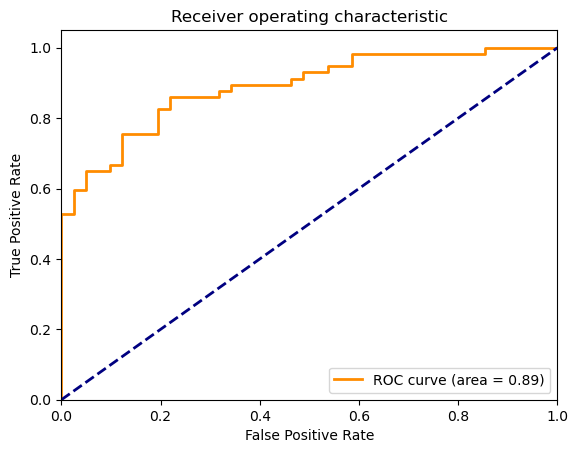

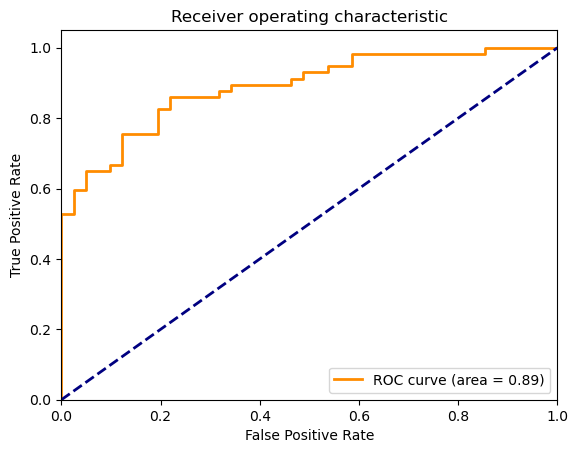

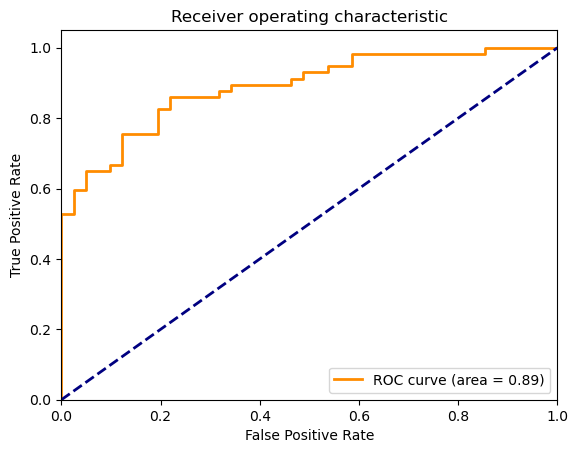

交叉验证得分：
[0.69230769 0.76923077 0.71794872 0.76923077 0.64102564 0.76923077
 0.79487179 0.76923077 0.79487179 0.68421053]
0.7402159244264508
交叉验证得分：
[0.69230769 0.76923077 0.71794872 0.76923077 0.64102564 0.76923077
 0.79487179 0.76923077 0.79487179 0.68421053]
0.7402159244264508
交叉验证得分：
[0.69230769 0.76923077 0.71794872 0.76923077 0.64102564 0.76923077
 0.79487179 0.76923077 0.79487179 0.68421053]
0.7402159244264508


In [12]:
from sklearn import svm
model = svm.SVC(kernel = 'linear')
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
coef = model.coef_
coef = np.abs(coef)
importances = np.sum(coef, axis=0)
indices = np.argsort(importances)[::-1] # 下标排序
print(importances.shape)
print(indices.shape)
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, selected_features[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.decision_function(X_test)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

GBM-RFE#

In [13]:
# RFECV
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=model,  # 学习器
              min_features_to_select=2,  # 最小选择的特征数量
              step=1,  # 移除特征个数
              cv=StratifiedKFold(10),  # 交叉验证次数
              scoring='accuracy',  # 学习器的评价标准
              verbose=0,
              n_jobs=-1
              ).fit(X, y)
X_RFECV = rfecv.transform(X)
print("RFECV特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfecv.n_features_)
print("全部特征等级 : %s" % list(rfecv.ranking_))

RFECV特征选择结果——————————————————————————————————————————————————
有效特征个数 : 20
全部特征等级 : [214, 212, 208, 206, 205, 23, 74, 68, 44, 66, 6, 56, 21, 48, 1, 90, 100, 20, 60, 33, 26, 1, 61, 15, 38, 86, 5, 25, 69, 64, 83, 71, 73, 133, 135, 82, 42, 141, 17, 70, 159, 134, 1, 183, 150, 3, 1, 140, 40, 1, 1, 126, 13, 1, 10, 128, 30, 52, 1, 37, 1, 1, 1, 108, 144, 162, 132, 123, 31, 118, 111, 45, 138, 202, 46, 167, 109, 57, 158, 166, 137, 200, 113, 120, 151, 169, 24, 67, 168, 62, 112, 107, 91, 7, 95, 72, 125, 201, 98, 143, 146, 153, 36, 170, 173, 50, 124, 122, 181, 184, 187, 189, 191, 193, 182, 209, 215, 217, 216, 207, 203, 19, 147, 142, 9, 152, 145, 93, 165, 32, 121, 16, 18, 105, 1, 22, 99, 94, 106, 49, 63, 96, 27, 1, 1, 78, 163, 2, 115, 88, 28, 55, 139, 75, 39, 97, 180, 157, 76, 29, 51, 116, 160, 110, 148, 156, 175, 179, 119, 154, 176, 188, 155, 34, 204, 164, 127, 102, 54, 14, 1, 172, 1, 77, 131, 161, 8, 210, 65, 178, 149, 12, 1, 130, 41, 136, 199, 47, 4, 81, 213, 129, 117, 114, 104, 103, 101, 89, 92, 

In [14]:
selected_features = X.columns[rfecv.support_]
print(list(selected_features))
print("交叉验证得分————————————————————————————————————————————")
print(rfecv.cv_results_["mean_test_score"])
U=X[selected_features]
X_train, X_test, Y_train, Y_test = train_test_split(U, y, test_size=0.2)

['4-Trimethylammoniobutanal', 'Paraxanthine', 'Bilirubin', '3-Methoxytyrosine', 'N-Alpha-acetyllysine', 'Ergothioneine', '7-Methylxanthine', 'Ascorbate', 'Dopamine 4-o-sulfate', 'Putrescine', 'cis-Aconitic acid', 'SM(d18:1/16:0)', 'TG(20:4_34:3)', 'TG(20:4_36:2)', 'PE(P-16:0/20:4)', 'PE(P-16:0/22:4)', 'PG(18:0_18:1)', 'BMP(22:6/22:6)', 'PA(18:1/18:1)', 'PG(16:0_20:4)']
交叉验证得分————————————————————————————————————————————
[0.85029762 0.89362245 0.91789966 0.91611395 0.92831633 0.92414966
 0.92210884 0.92406463 0.92206633 0.92818878 0.92619048 0.92198129
 0.92202381 0.92606293 0.93635204 0.93014456 0.93222789 0.93414116
 0.94238946 0.93826531 0.93222789 0.93635204 0.93835034 0.94039116
 0.94043367 0.92810374 0.92397959 0.91985544 0.92189626 0.92806122
 0.91981293 0.93418367 0.91777211 0.93005952 0.93001701 0.93418367
 0.93210034 0.93005952 0.91985544 0.93418367 0.92602041 0.92389456
 0.92801871 0.92189626 0.93005952 0.92606293 0.92602041 0.92393707
 0.92597789 0.93010204 0.92189626 0.92393

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.445990
 2) 3-Methoxytyrosine              0.251377
 3) Dopamine 4-o-sulfate           0.092341
 4) PG(16:0_20:4)                  0.039806
 5) TG(20:4_36:2)                  0.032405
 6) Bilirubin                      0.021883
 7) 7-Methylxanthine               0.020567
 8) Ergothioneine                  0.016840
 9) Ascorbate                      0.016436
10) Paraxanthine                   0.014292
11) PA(18:1/18:1)                  0.012142
12) PE(P-16:0/20:4)                0.010923
13) BMP(22:6/22:6)                 0.008296
14) 4-Trimethylammoniobutanal      0.008017
15) N-Alpha-acetyllysine           0.003579
16) PG(18:0_18:1)                  0.002300
17) PE(P-16:0/22:4)                0.001820
18) SM(d18:1/16:0)                 0.000829
19) cis-Aconitic acid              0.000154
20) TG(20:4_34:3)                  0.000003
准确率:98.98%
精确率: 0 : 97.22 %
精确率: 1 : 100.0 %
召回率: 0 : 100.0 %
召

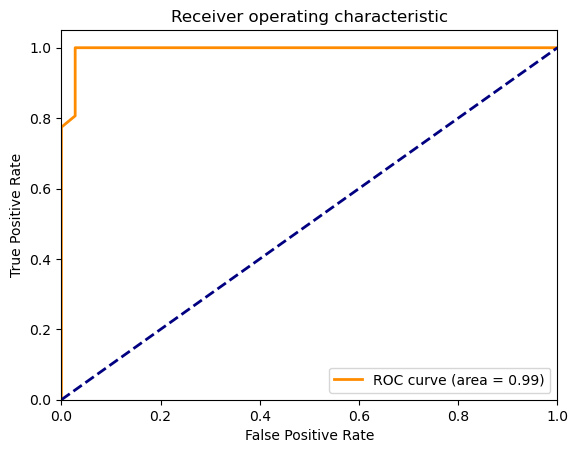

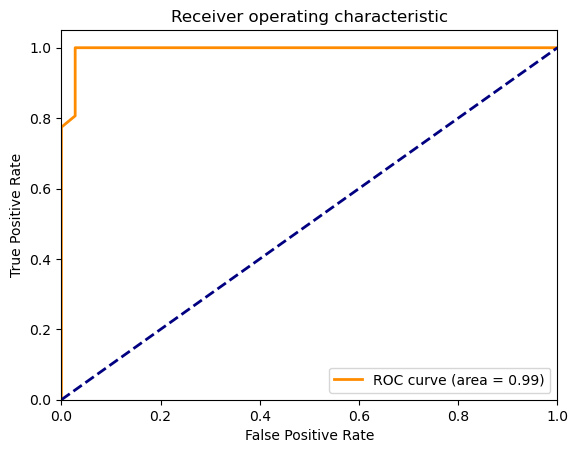

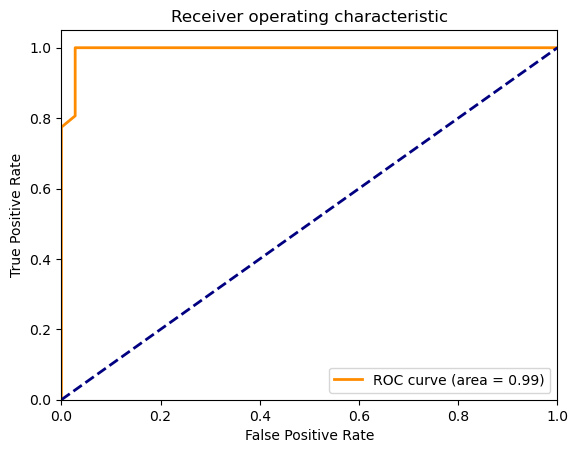

交叉验证得分：
[0.94871795 0.94871795 0.97435897 0.97435897 1.         0.8974359
 0.94871795 0.94871795 0.94871795 0.97368421]
0.9563427800269905
交叉验证得分：
[0.94871795 0.94871795 0.97435897 0.97435897 1.         0.8974359
 0.94871795 0.94871795 0.94871795 0.97368421]
0.9563427800269905
交叉验证得分：
[0.94871795 0.94871795 0.97435897 0.97435897 1.         0.8974359
 0.94871795 0.94871795 0.94871795 0.97368421]
0.9563427800269905


In [15]:

model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, selected_features[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())